## The Project: Simulated Machine Learning Production System

### Overview

This project demonstrates how to simulate a **real-world ML production environment** using **FastAPI**, **Scikit-learn**, and **ngrok**.
It replicates the core lifecycle of deploying, serving, monitoring, and comparing multiple model versions (v1, v2) in a live API — exactly as would happen in an enterprise production system.

---

### 1. Objective

The goal is to show how an ML model moves from **training** to **deployment** and **real-time monitoring**, simulating a real production workflow.
It includes:

* Training and versioning multiple models
* Deploying the models as REST APIs
* Routing live requests between versions (Canary Deployment)
* Collecting and analyzing performance metrics

---

### 2. Model Training and Versioning

Two independent models are trained on the **Iris dataset**:

* **Version 1 (v1):** Logistic Regression
* **Version 2 (v2):** Random Forest Classifier

Both are saved with version identifiers:

```python
joblib.dump(LogisticRegression(max_iter=200).fit(X, y), "iris_model_v1.joblib")
joblib.dump(RandomForestClassifier(n_estimators=100).fit(X, y), "iris_model_v2.joblib")
```

In a real ML production pipeline, these models could be stored in a **Model Registry** or **Artifact Store** (e.g., MLflow, S3, GCS).

---

### 3. Model Serving with FastAPI

The models are deployed behind a **FastAPI** service that exposes two endpoints:

* `GET /` – Returns API status
* `POST /predict` – Accepts JSON input and returns predictions

Example request:

```json
{"features": [5.1, 3.5, 1.4, 0.2]}
```

Example response:

```json
{"prediction": "setosa"}
```

The API loads models dynamically using `joblib.load()`, just like a live inference service would load the latest production model.

---

### 4. Canary Deployment Simulation

To emulate a **production rollout**, requests are distributed between two models:

* **80%** of incoming requests → **v1 (stable model)**
* **20%** → **v2 (candidate model)**

This setup tests v2 performance under real traffic before full release.

Implementation:

```python
use_v2 = random.random() < 0.2
model_path = "iris_model_v2.joblib" if use_v2 else "iris_model_v1.joblib"
```

In practice, this is equivalent to a **Canary Deployment**, where a small percentage of users are exposed to the new model to verify its reliability and accuracy.

---

### 5. Public Deployment via ngrok

Since the environment is local or in Colab, **ngrok** is used to simulate public deployment.
It exposes the FastAPI server through a secure, temporary public URL:

```python
public_url = ngrok.connect(8000)
```

This mirrors how production models are accessed by clients or external systems through RESTful endpoints.

---

### 6. Real-Time Monitoring and Evaluation

The system sends multiple simulated client requests to the deployed API and records:

* Which model handled the request (v1 or v2)
* The model’s latency (response time)
* Whether the prediction was correct (compared to ground truth)

Example output:

```
=== Canary Performance Summary ===
Total requests: 50
v1 served: 40 (80.0%)
v2 served: 10 (20.0%)
v1 latency avg: 4.23 ms
v1 accuracy: 97.5%
v2 latency avg: 5.10 ms
v2 accuracy: 100.0%
```

Results are saved to `canary_log.json`, simulating **monitoring logs** and **model metrics** as in real A/B tests.

---

### 7. Key Production Concepts Demonstrated

| Concept                   | Description                                                 |
| ------------------------- | ----------------------------------------------------------- |
| **Model Versioning**      | Managing multiple models (v1, v2)                           |
| **Canary Deployment**     | Safe rollout with partial traffic exposure                  |
| **Live Inference API**    | Serving real-time predictions via REST                      |
| **Monitoring & Logging**  | Tracking latency, accuracy, and usage per model             |
| **Continuous Evaluation** | Detecting regressions in performance before full deployment |

---

### 8. How This Simulates a Real Production System

This environment mimics a **full ML operations (MLOps)** pipeline on a smaller scale:

* **Training → Deployment → Monitoring → Iteration**
* Each request acts like a real user query
* Logs and metrics mimic what production systems send to monitoring tools such as Prometheus, Grafana, or Sentry
* Canary logic ensures risk-free testing of new models in production-like conditions

---

### Conclusion

This project is a complete **simulation of an ML production pipeline**, showing how to:

1. Train and version models
2. Deploy them using a scalable API
3. Gradually introduce new versions safely
4. Monitor performance in real time



In [ ]:
# ===========================================
# 1. Install dependencies
# ===========================================
!pip install fastapi uvicorn nest_asyncio pyngrok scikit-learn joblib

In [3]:
import joblib
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from fastapi import FastAPI
from pydantic import BaseModel
import nest_asyncio, threading
from pyngrok import ngrok
import uvicorn

# --- Train and save model ---
iris = load_iris()
X, y = iris.data, iris.target
model = LogisticRegression(max_iter=200)
model.fit(X, y)
joblib.dump(model, "iris_model_v1.joblib")
print("Model trained and saved")

Model trained and saved


In [4]:
# --- Define API ---
app = FastAPI(title="Iris Model API")

class FeaturesRequest(BaseModel):
    features: list[float]

@app.get("/")
def root():
    return {"message": "Iris API is running successfully!"}

@app.post("/predict")
def predict(request: FeaturesRequest):
    model = joblib.load("iris_model_v1.joblib")
    X_input = np.array(request.features).reshape(1, -1)
    pred = int(model.predict(X_input)[0])
    return {"prediction": iris.target_names[pred]}

# ===========================================
# Clean previous servers and tunnels
# ===========================================
!fuser -k 8000/tcp || true   # סוגר שרתים שרצים על פורט 8000
from pyngrok import ngrok
ngrok.kill()                 # סוגר מנהרות ngrok פתוחות
print("Cleared old servers and tunnels.")

# --- Run server ---
ngrok.kill()
public_url = ngrok.connect(8000)
print("Public URL:", public_url)

nest_asyncio.apply()

def run_api():
    uvicorn.run(app, host="0.0.0.0", port=8000, log_level="info")

thread = threading.Thread(target=run_api)
thread.start()


Cleared old servers and tunnels.
Public URL: NgrokTunnel: "https://370afc0ddeb7.ngrok-free.app" -> "http://localhost:8000"


# One prediction

In [7]:
import requests

url = "https://370afc0ddeb7.ngrok-free.app/predict"  # שים את הכתובת שלך מהפלט למעלה
sample = [5.1, 3.5, 1.4, 0.2]

response = requests.post(url, json={"features": sample})
print(response.json())


INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
{'prediction': 'setosa'}


# AB Testing

In [8]:
# Run once – outside API
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

iris = load_iris()
X, y = iris.data, iris.target

# Train and save both models
joblib.dump(LogisticRegression(max_iter=200).fit(X, y), "iris_model_v1.joblib")
joblib.dump(RandomForestClassifier(n_estimators=100).fit(X, y), "iris_model_v2.joblib")

print("Models saved: v1 (LogReg), v2 (RandomForest)")

Models saved: v1 (LogReg), v2 (RandomForest)


In [1]:
# ===========================================
# FastAPI Canary Deployment (v1 vs v2)
# ===========================================
#!pip install fastapi uvicorn nest_asyncio pyngrok scikit-learn joblib

import random, joblib, numpy as np
from fastapi import FastAPI
from pydantic import BaseModel
from sklearn.datasets import load_iris
import uvicorn, nest_asyncio, threading
from pyngrok import ngrok

# Load iris info
iris = load_iris()

# =============================
# 1. Define API
# =============================
app = FastAPI(title="Iris Canary API")

class FeaturesRequest(BaseModel):
    features: list[float]

@app.get("/")
def root():
    return {"message": "Iris Canary Deployment API running (80% v1, 20% v2)"}

@app.post("/predict")
def predict(request: FeaturesRequest):
    # Randomly choose version: 80% v1, 20% v2
    use_v2 = random.random() < 0.2
    model_path = "iris_model_v2.joblib" if use_v2 else "iris_model_v1.joblib"
    model = joblib.load(model_path)

    X_input = np.array(request.features).reshape(1, -1)
    pred = int(model.predict(X_input)[0])
    return {
        "model_used": "v2" if use_v2 else "v1",
        "prediction": iris.target_names[pred]
    }

# =============================
# 2. Run server inside Colab
# =============================
!fuser -k 8000/tcp || true
ngrok.kill()

nest_asyncio.apply()
public_url = ngrok.connect(8000)
print("Public URL:", public_url)

def run_api():
    uvicorn.run(app, host="0.0.0.0", port=8000, log_level="info")

thread = threading.Thread(target=run_api)
thread.start()


Public URL: NgrokTunnel: "https://320703514572.ngrok-free.app" -> "http://localhost:8000"


In [2]:
# ===========================================
# Real-Time Canary Monitoring (English only)
# ===========================================
import requests
import time
import statistics
import json
from sklearn.datasets import load_iris

# URL of your deployed API
url = "https://320703514572.ngrok-free.app/predict"  # replace with your ngrok URL

# Load dataset for evaluation
iris = load_iris()
X, y = iris.data, iris.target
target_names = iris.target_names

# Monitoring parameters
n_requests = 50
results = []
v1_times, v2_times = [], []
v1_correct, v2_correct = 0, 0
v1_total, v2_total = 0, 0

print("Sending test requests to Canary API...\n")

for i in range(n_requests):
    features = X[i % len(X)].tolist()
    true_label = target_names[y[i % len(X)]]

    # Measure latency
    t0 = time.time()
    r = requests.post(url, json={"features": features})
    elapsed = (time.time() - t0) * 1000  # milliseconds

    if r.status_code == 200:
        data = r.json()
        model_used = data.get("model_used", "unknown")
        prediction = data.get("prediction", "N/A")

        correct = (prediction == true_label)
        results.append({
            "model": model_used,
            "prediction": prediction,
            "true_label": true_label,
            "time_ms": round(elapsed, 2),
            "correct": correct
        })

        # Accumulate statistics
        if model_used == "v1":
            v1_times.append(elapsed)
            v1_total += 1
            if correct:
                v1_correct += 1
        else:
            v2_times.append(elapsed)
            v2_total += 1
            if correct:
                v2_correct += 1
    else:
        print(f"Request {i+1} failed (status {r.status_code})")

# ===========================================
# Summary statistics
# ===========================================
print("\n=== Canary Performance Summary ===")
print(f"Total requests: {n_requests}")
print(f"v1 served: {v1_total} ({(v1_total/n_requests)*100:.1f}%)")
print(f"v2 served: {v2_total} ({(v2_total/n_requests)*100:.1f}%)")

if v1_total:
    print(f"v1 latency avg: {statistics.mean(v1_times):.2f} ms")
    print(f"v1 accuracy: {v1_correct/v1_total:.2%}")
if v2_total:
    print(f"v2 latency avg: {statistics.mean(v2_times):.2f} ms")
    print(f"v2 accuracy: {v2_correct/v2_total:.2%}")

# Save detailed log
with open("canary_log.json", "w") as f:
    json.dump(results, f, indent=2)

print("\nLogs saved to canary_log.json (sample preview):")
print(json.dumps(results[:5], indent=2))


Sending test requests to Canary API...

INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict H

In [5]:
# ===========================================
# A/B Testing (post-experiment analysis)
# ===========================================
# This cell evaluates A/B performance using the API responses.
# It computes accuracy and latency per model (A=v1, B=v2),
# runs statistical tests, and prints a concise recommendation.

import requests
import time
import statistics
import json
import math
from sklearn.datasets import load_iris

# API endpoint (replace with your ngrok URL)
URL = "https://320703514572.ngrok-free.app/predict"  # replace with your URL

# Load ground truth for evaluation
iris = load_iris()
X, y = iris.data, iris.target
target_names = iris.target_names

# Experiment parameters
N_REQUESTS = 100  # total requests
TIMEOUT = 20      # seconds per request timeout

# Logs
logs = []
lat_v1, lat_v2 = [], []
ok_v1 = ok_v2 = 0
n_v1 = n_v2 = 0
failures = 0

print("Running A/B test requests...")

for i in range(N_REQUESTS):
    features = X[i % len(X)].tolist()
    true_label = target_names[y[i % len(X)]]
    t0 = time.time()
    try:
        r = requests.post(URL, json={"features": features}, timeout=TIMEOUT)
        elapsed_ms = (time.time() - t0) * 1000.0
        if r.status_code != 200:
            failures += 1
            continue
        payload = r.json()
        model_used = payload.get("model_used", "unknown")
        pred = payload.get("prediction", None)
        correct = (pred == true_label)

        logs.append({
            "model_used": model_used,
            "prediction": pred,
            "true_label": true_label,
            "latency_ms": round(elapsed_ms, 2),
            "correct": bool(correct)
        })

        if model_used == "v1":
            n_v1 += 1
            lat_v1.append(elapsed_ms)
            ok_v1 += int(correct)
        elif model_used == "v2":
            n_v2 += 1
            lat_v2.append(elapsed_ms)
            ok_v2 += int(correct)
        else:
            # unrecognized model label, count as failure
            failures += 1
    except Exception:
        failures += 1

# Helper functions
def mean(lst):
    return sum(lst) / len(lst) if lst else float("nan")

def p95(lst):
    if not lst:
        return float("nan")
    s = sorted(lst)
    k = int(math.ceil(0.95 * len(s))) - 1
    return s[max(0, min(k, len(s)-1))]

def two_proportion_z_test(success1, total1, success2, total2):
    # Returns (z, p_value_approx_two_tailed)
    if total1 == 0 or total2 == 0:
        return float("nan"), float("nan")
    p1 = success1 / total1
    p2 = success2 / total2
    p_pool = (success1 + success2) / (total1 + total2)
    se = math.sqrt(p_pool * (1 - p_pool) * (1/total1 + 1/total2))
    if se == 0:
        return float("nan"), float("nan")
    z = (p1 - p2) / se
    # Approximate two-tailed p-value using normal distribution
    # erf-based approximation:
    from math import erf, sqrt
    p_value = 2 * (1 - 0.5 * (1 + erf(abs(z) / sqrt(2))))
    return z, p_value

# Accuracy
acc_v1 = ok_v1 / n_v1 if n_v1 else float("nan")
acc_v2 = ok_v2 / n_v2 if n_v2 else float("nan")

# Latency stats
lat_v1_mean = mean(lat_v1)
lat_v2_mean = mean(lat_v2)
lat_v1_p95 = p95(lat_v1)
lat_v2_p95 = p95(lat_v2)

# Significance test for accuracy difference (two-proportion z-test)
z_acc, p_acc = two_proportion_z_test(ok_v1, n_v1, ok_v2, n_v2)



Running A/B test requests...
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.194.235.237:0 - "POST /predict HTTP/1.1" 20

In [6]:
# ===========================================
# A/B Testing – Additional Analyses (English-only comments)
# ===========================================
# This cell loads "ab_test_log.json" from the previous step and performs:
# 1) Fisher's exact test for accuracy difference (robust for small samples)
# 2) Bootstrap 95% CI for accuracy uplift (v2 - v1)
# 3) Bayesian comparison for accuracy: P(p_v2 > p_v1) with Beta(1,1) priors
# 4) Latency tests: Mann–Whitney U (non-parametric), Welch's t-test, and Cliff's delta
# 5) Bootstrap 95% CI for latency mean difference (v2 - v1)
# 6) MDE (Minimum Detectable Effect) for accuracy at alpha=0.05, power=0.8

import json
import math
import random
import numpy as np
from pathlib import Path
from statistics import mean
from scipy.stats import fisher_exact, mannwhitneyu, ttest_ind, norm

print("\n=== A/B Test Summary ===")
print(f"Total requests sent: {N_REQUESTS}")
print(f"Failures (non-200 or parsing): {failures}")
print(f"Group A (v1) count: {n_v1}")
print(f"Group B (v2) count: {n_v2}")

print("\nAccuracy:")
print(f" A (v1): {acc_v1:.4f}  [{ok_v1}/{n_v1}]")
print(f" B (v2): {acc_v2:.4f}  [{ok_v2}/{n_v2}]")
print(f" Two-proportion Z-test: z={z_acc:.3f}, p≈{p_acc:.4f}")

print("\nLatency (ms):")
print(f" A (v1): mean={lat_v1_mean:.2f}, p95={lat_v1_p95:.2f}")
print(f" B (v2): mean={lat_v2_mean:.2f}, p95={lat_v2_p95:.2f}")

# Optional: save detailed log for further analysis
with open("ab_test_log.json", "w") as f:
    json.dump(logs, f, indent=2)

print("\nSaved detailed logs to ab_test_log.json")

# Simple recommendation based on accuracy primary, latency secondary
def recommend():
    # If accuracy difference is significant at p<0.05, choose higher accuracy
    if all(map(lambda v: not math.isnan(v), [p_acc, acc_v1, acc_v2])):
        if p_acc < 0.05:
            if acc_v2 > acc_v1:
                return "Recommend promoting v2 based on significantly higher accuracy (p<0.05)."
            elif acc_v1 > acc_v2:
                return "Recommend keeping v1 based on significantly higher accuracy (p<0.05)."
    # If accuracy not significant, consider latency p95
    if not math.isnan(lat_v1_p95) and not math.isnan(lat_v2_p95):
        if lat_v2_p95 + 1e-9 < lat_v1_p95 and (abs(acc_v2 - acc_v1) < 0.005 or math.isnan(p_acc) or p_acc >= 0.05):
            return "Accuracy difference is not significant; v2 shows lower p95 latency. Consider promoting v2."
        if lat_v1_p95 + 1e-9 < lat_v2_p95 and (abs(acc_v2 - acc_v1) < 0.005 or math.isnan(p_acc) or p_acc >= 0.05):
            return "Accuracy difference is not significant; v1 shows lower p95 latency. Consider keeping v1."
    return "No clear winner; collect more traffic or extend test duration."

print("\nRecommendation:")
print(recommend())


# ---------- Load logs ----------
log_path = Path("ab_test_log.json")
if not log_path.exists():
    raise FileNotFoundError("ab_test_log.json not found. Run the previous A/B test cell first.")
with open(log_path, "r") as f:
    logs = json.load(f)

# ---------- Split by variant ----------
v1_acc_flags, v2_acc_flags = [], []
v1_lat, v2_lat = [], []
for row in logs:
    if row.get("model_used") == "v1":
        v1_acc_flags.append(1 if row.get("correct") else 0)
        v1_lat.append(float(row.get("latency_ms", float("nan"))))
    elif row.get("model_used") == "v2":
        v2_acc_flags.append(1 if row.get("correct") else 0)
        v2_lat.append(float(row.get("latency_ms", float("nan"))))

n1, n2 = len(v1_acc_flags), len(v2_acc_flags)
ok1, ok2 = sum(v1_acc_flags), sum(v2_acc_flags)
fail1, fail2 = n1 - ok1, n2 - ok2

acc1 = ok1 / n1 if n1 else float("nan")
acc2 = ok2 / n2 if n2 else float("nan")
uplift = acc2 - acc1

# ---------- Helpers ----------
def bootstrap_ci(data, stat_fn, n_boot=10000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    arr = np.array(data)
    stats = []
    n = len(arr)
    if n == 0:
        return (float("nan"), float("nan"))
    for _ in range(n_boot):
        sample = rng.choice(arr, size=n, replace=True)
        stats.append(stat_fn(sample))
    lo = np.percentile(stats, 100*alpha/2)
    hi = np.percentile(stats, 100*(1 - alpha/2))
    return float(lo), float(hi)

def bootstrap_ci_two_sample(a, b, stat_fn, n_boot=10000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    A = np.array(a)
    B = np.array(b)
    if len(A) == 0 or len(B) == 0:
        return (float("nan"), float("nan"))
    stats = []
    for _ in range(n_boot):
        sa = rng.choice(A, size=len(A), replace=True)
        sb = rng.choice(B, size=len(B), replace=True)
        stats.append(stat_fn(sa, sb))
    lo = np.percentile(stats, 100*alpha/2)
    hi = np.percentile(stats, 100*(1 - alpha/2))
    return float(lo), float(hi)

def cliffs_delta(x, y):
    # Measures effect size for ordinal/continuous data
    X = np.array(x)
    Y = np.array(y)
    n_x, n_y = len(X), len(Y)
    if n_x == 0 or n_y == 0:
        return float("nan")
    # Efficient pairwise comparison using broadcasting for moderate sizes
    diff = X[:, None] - Y[None, :]
    n_greater = np.sum(diff > 0)
    n_less = np.sum(diff < 0)
    delta = (n_greater - n_less) / (n_x * n_y)
    return float(delta)

# ---------- 1) Fisher's exact test for accuracy ----------
table = np.array([[ok1, fail1],
                  [ok2, fail2]])
# 'two-sided' p-value for difference in proportions
_, p_fisher = fisher_exact(table, alternative='two-sided')

# ---------- 2) Bootstrap CI for accuracy uplift ----------
# Treat accuracy as Bernoulli; bootstrap the difference in means
uplift_lo, uplift_hi = bootstrap_ci_two_sample(
    v2_acc_flags, v1_acc_flags,
    stat_fn=lambda b, a: np.mean(b) - np.mean(a),
    n_boot=10000, alpha=0.05, seed=123
)

# ---------- 3) Bayesian accuracy comparison ----------
# Beta(1,1) prior for each variant (uniform)
# Posterior: Beta(1 + successes, 1 + failures)
rng = np.random.default_rng(123)
S = 20000
post_v1 = rng.beta(1 + ok1, 1 + fail1, size=S) if n1 else np.array([])
post_v2 = rng.beta(1 + ok2, 1 + fail2, size=S) if n2 else np.array([])
if post_v1.size and post_v2.size:
    prob_v2_better = float(np.mean(post_v2 > post_v1))
    bayes_ci_v1 = (float(np.percentile(post_v1, 2.5)), float(np.percentile(post_v1, 97.5)))
    bayes_ci_v2 = (float(np.percentile(post_v2, 2.5)), float(np.percentile(post_v2, 97.5)))
else:
    prob_v2_better = float("nan")
    bayes_ci_v1 = (float("nan"), float("nan"))
    bayes_ci_v2 = (float("nan"), float("nan"))

# ---------- 4) Latency tests ----------
v1_lat = [x for x in v1_lat if not math.isnan(x)]
v2_lat = [x for x in v2_lat if not math.isnan(x)]

# Mann–Whitney U (non-parametric, tests shift in distributions)
if len(v1_lat) and len(v2_lat):
    u_stat, p_mwu = mannwhitneyu(v1_lat, v2_lat, alternative="two-sided")
else:
    u_stat, p_mwu = float("nan"), float("nan")

# Welch's t-test for difference in means (unequal variances)
if len(v1_lat) and len(v2_lat):
    t_stat, p_welch = ttest_ind(v1_lat, v2_lat, equal_var=False)
else:
    t_stat, p_welch = float("nan"), float("nan")

# Cliff's delta for effect size
delta = cliffs_delta(v2_lat, v1_lat)  # positive means v2 tends to be larger (slower)

# ---------- 5) Bootstrap CI for latency mean difference (v2 - v1) ----------
lat_diff_lo, lat_diff_hi = bootstrap_ci_two_sample(
    v2_lat, v1_lat,
    stat_fn=lambda b, a: float(np.mean(b) - np.mean(a)),
    n_boot=10000, alpha=0.05, seed=123
)

# ---------- 6) MDE for accuracy (two-sample proportions) ----------
# Approximates the minimal detectable absolute uplift given current sizes,
# alpha=0.05 (two-sided), power=0.8.
def mde_two_proportions(p_base, nA, nB, alpha=0.05, power=0.8):
    if nA == 0 or nB == 0 or math.isnan(p_base):
        return float("nan")
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(power)
    se = math.sqrt(p_base * (1 - p_base) * (1/nA + 1/nB))
    return (z_alpha + z_beta) * se

mde_abs = mde_two_proportions(acc1, n1, n2, alpha=0.05, power=0.8)

# ---------- Print summary ----------
print("=== Additional A/B Analyses ===")
print(f"Samples: v1={n1}, v2={n2}")
print(f"Accuracy: v1={acc1:.4f} [{ok1}/{n1}], v2={acc2:.4f} [{ok2}/{n2}]")
print(f"Accuracy uplift (v2 - v1): {uplift:.4f}")
print(f"Fisher's exact test p-value: {p_fisher:.4f}")
print(f"Bootstrap 95% CI for accuracy uplift: [{uplift_lo:.4f}, {uplift_hi:.4f}]")
print(f"Bayesian Beta(1,1): P(p_v2 > p_v1) ≈ {prob_v2_better:.4f}")
print(f"Bayesian 95% CI: v1={bayes_ci_v1}, v2={bayes_ci_v2}")

if len(v1_lat) and len(v2_lat):
    print("\nLatency (ms):")
    print(f"v1 mean={mean(v1_lat):.2f}, v2 mean={mean(v2_lat):.2f}")
    print(f"Mann–Whitney U p-value: {p_mwu:.4f}")
    print(f"Welch's t-test p-value: {p_welch:.4f}")
    print(f"Cliff's delta (v2 vs v1): {delta:.3f}  (positive => v2 tends to be slower)")
    print(f"Bootstrap 95% CI for mean latency diff (v2 - v1): [{lat_diff_lo:.2f}, {lat_diff_hi:.2f}]")
else:
    print("\nLatency analysis skipped due to missing data.")

print("\nMDE (accuracy, absolute) at alpha=0.05, power=0.8:")
print(f"MDE ≈ {mde_abs:.4f} (absolute). If uplift is smaller than this, the test is likely underpowered.")



=== A/B Test Summary ===
Total requests sent: 100
Failures (non-200 or parsing): 0
Group A (v1) count: 79
Group B (v2) count: 21

Accuracy:
 A (v1): 0.9620  [76/79]
 B (v2): 1.0000  [21/21]
 Two-proportion Z-test: z=-0.907, p≈0.3646

Latency (ms):
 A (v1): mean=671.22, p95=814.36
 B (v2): mean=675.85, p95=821.04

Saved detailed logs to ab_test_log.json

Recommendation:
Accuracy difference is not significant; v1 shows lower p95 latency. Consider keeping v1.
=== Additional A/B Analyses ===
Samples: v1=79, v2=21
Accuracy: v1=0.9620 [76/79], v2=1.0000 [21/21]
Accuracy uplift (v2 - v1): 0.0380
Fisher's exact test p-value: 1.0000
Bootstrap 95% CI for accuracy uplift: [0.0000, 0.0886]
Bayesian Beta(1,1): P(p_v2 > p_v1) ≈ 0.6272
Bayesian 95% CI: v1=(0.8940940689438424, 0.9861898664203274), v2=(0.846320761627684, 0.9988194104910613)

Latency (ms):
v1 mean=671.22, v2 mean=675.85
Mann–Whitney U p-value: 0.0569
Welch's t-test p-value: 0.8507
Cliff's delta (v2 vs v1): 0.272  (positive => v2 tends 

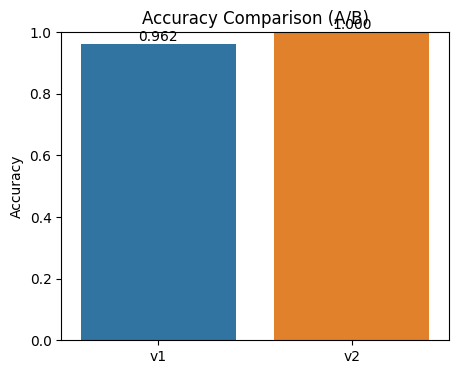

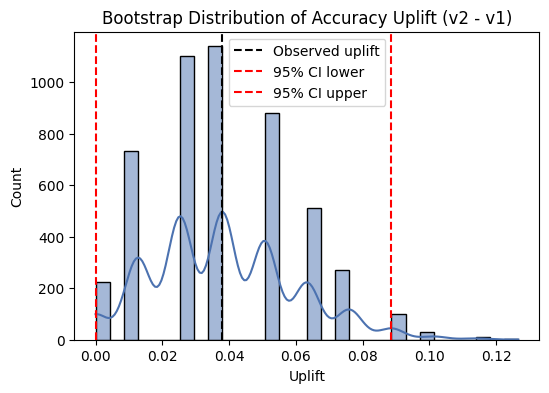

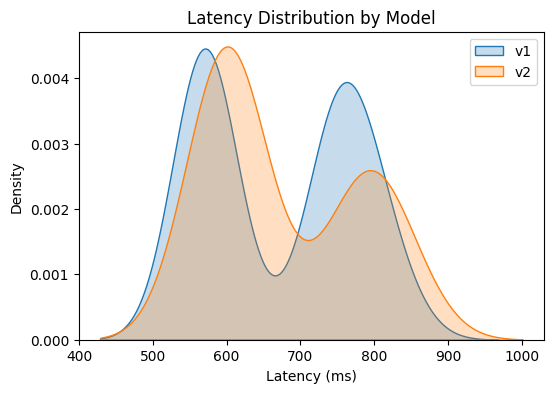

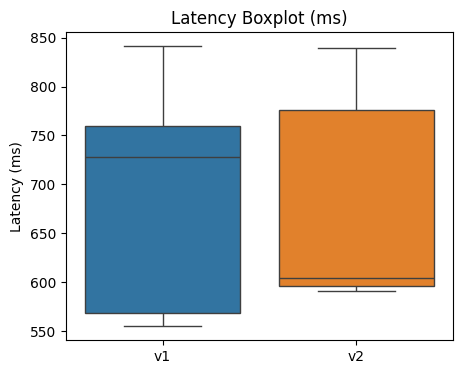

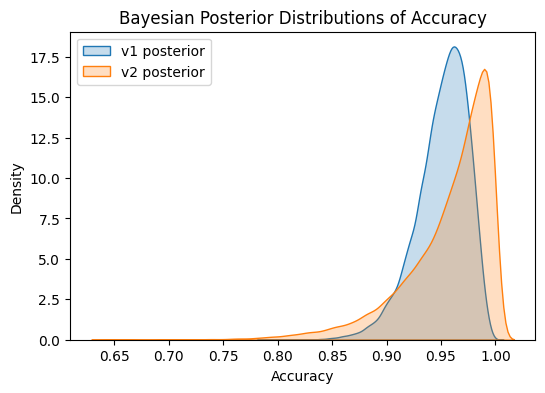

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------------
# 1. Accuracy comparison bar chart
# -----------------------------------------------
plt.figure(figsize=(5, 4))
sns.barplot(x=["v1", "v2"], y=[acc1, acc2], hue=["v1", "v2"], legend=False,
            palette=["#1f77b4", "#ff7f0e"])
plt.title("Accuracy Comparison (A/B)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, v in enumerate([acc1, acc2]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontsize=10)
plt.show()

# -----------------------------------------------
# 2. Bootstrap accuracy uplift distribution
# -----------------------------------------------
uplift_samples = []
rng = np.random.default_rng(42)
for _ in range(5000):
    s1 = rng.choice(v1_acc_flags, len(v1_acc_flags), replace=True)
    s2 = rng.choice(v2_acc_flags, len(v2_acc_flags), replace=True)
    uplift_samples.append(np.mean(s2) - np.mean(s1))

plt.figure(figsize=(6, 4))
sns.histplot(uplift_samples, kde=True, bins=30, color="#4c72b0")
plt.axvline(uplift, color="black", linestyle="--", label="Observed uplift")
plt.axvline(uplift_lo, color="red", linestyle="--", label="95% CI lower")
plt.axvline(uplift_hi, color="red", linestyle="--", label="95% CI upper")
plt.title("Bootstrap Distribution of Accuracy Uplift (v2 - v1)")
plt.xlabel("Uplift")
plt.legend()
plt.show()

# -----------------------------------------------
# 3. Latency distribution by model
# -----------------------------------------------
plt.figure(figsize=(6, 4))
sns.kdeplot(v1_lat, label="v1", fill=True)
sns.kdeplot(v2_lat, label="v2", fill=True)
plt.title("Latency Distribution by Model")
plt.xlabel("Latency (ms)")
plt.ylabel("Density")
plt.legend()
plt.show()

# -----------------------------------------------
# 4. Latency boxplot
# -----------------------------------------------
plt.figure(figsize=(5, 4))
sns.boxplot(data=[v1_lat, v2_lat])
plt.xticks([0, 1], ["v1", "v2"])
plt.title("Latency Boxplot (ms)")
plt.ylabel("Latency (ms)")
plt.show()

# -----------------------------------------------
# 5. Bayesian posterior comparison
# -----------------------------------------------
plt.figure(figsize=(6, 4))
sns.kdeplot(post_v1, label="v1 posterior", fill=True)
sns.kdeplot(post_v2, label="v2 posterior", fill=True)
plt.title("Bayesian Posterior Distributions of Accuracy")
plt.xlabel("Accuracy")
plt.legend()
plt.show()


## Understanding the Statistical Methods Used in A/B Testing

This section explains, in simple terms, what each statistical measure or test means and how to interpret when results are **statistically different**.

---

### 1. **Mean Latency**

* **Definition:** The arithmetic average of all response times.
  Example: If three requests take 100, 200, and 300 ms, the mean is 200 ms.
* **Use:** Measures central tendency—how fast a model typically responds.
* **Statistical Difference:** Two groups are considered *statistically different* if their mean latencies differ significantly (for example, based on a t-test p < 0.05).

---

### 2. **95th Percentile (p95)**

* **Definition:** The latency value below which 95% of all requests fall.
  It highlights **tail performance**—occasional slow requests.
* **Use:** Important in production systems to detect outliers and ensure reliability.
* **Statistical Difference:** Differences in p95 are often inspected visually or tested using **non-parametric** methods (like Mann–Whitney) because tail data are not normally distributed.

---

### 3. **Mann–Whitney U Test**

* **Type:** **Non-parametric** test (does not assume normal distribution).
* **Goal:** Tests whether one group’s values are systematically higher than the other’s by comparing ranks rather than means.
* **Interpretation:**

  * **Null hypothesis (H₀):** Both groups come from the same distribution.
  * **If p < 0.05:** Reject H₀ → distributions are statistically different.
  * **If p ≥ 0.05:** No significant difference is detected.
* **Use Case:** Robust for latency or skewed data (not symmetric).

---

### 4. **Welch’s t-test**

* **Type:** **Parametric** test (assumes approximately normal data but allows unequal variances).
* **Goal:** Compares the **means** of two groups.
* **Interpretation:**

  * **H₀:** Mean₁ = Mean₂
  * **If p < 0.05:** There is a statistically significant difference in means.
  * **If p ≥ 0.05:** No significant difference in average performance.
* **Use Case:** Works well for large samples or roughly normal data.

---

### 5. **Cliff’s Delta (δ)**

* **Type:** **Effect size** measure, not a significance test.
* **Goal:** Quantifies how often values in one group are greater than in another.
* **Range:**

  * δ = 0 → No difference
  * δ ≈ ±0.11 → Small effect
  * δ ≈ ±0.28 → Medium effect
  * δ ≈ ±0.43 → Large effect
* **Interpretation:** Positive δ means the second group tends to have higher values (e.g., slower latency).
* **Use Case:** Always report alongside p-values to show *practical* impact, not just statistical significance.

---

### 6. **Bootstrap Confidence Interval (CI)**

* **Type:** **Resampling-based** estimation method.
* **Goal:** Estimates the likely range of the true metric (like mean difference or accuracy uplift) by repeatedly sampling the data with replacement.
* **Interpretation:**

  * 95% CI means we are 95% confident the true difference lies within this range.
  * **If CI includes 0:** No significant difference (cannot reject equality).
  * **If CI does not include 0:** Statistically different.
* **Use Case:** Useful when sample sizes are small or when distribution shape is unknown.

---

### 7. **Fisher’s Exact Test**

* **Type:** **Exact test** for 2×2 categorical tables (e.g., correct/incorrect outcomes).
* **Goal:** Determines whether success rates differ between groups.
* **Interpretation:**

  * **H₀:** Both groups have the same success probability.
  * **If p < 0.05:** The proportions differ significantly.
  * **If p ≥ 0.05:** No significant difference.
* **Use Case:** Works best for **small sample sizes** or binary outcomes (like accuracy).

---

### 8. **Bayesian Comparison (Beta Distributions)**

* **Type:** **Probabilistic estimation** instead of hypothesis testing.
* **Goal:** Computes the probability that one version’s metric (e.g., accuracy) is higher than the other’s using posterior distributions.
* **Interpretation:**

  * Example: P(p₂ > p₁) = 0.90 → There’s a 90% probability that version 2 is better.
  * No arbitrary cutoff like p < 0.05; instead, we reason in terms of probabilities.
* **Use Case:** Preferred for continuous monitoring, as it gives intuitive, interpretable results.

---

### 9. **Minimum Detectable Effect (MDE)**

* **Definition:** The **smallest true difference** that a test can detect with chosen significance (α) and power (1−β).
* **Use:** Helps decide whether an experiment has enough traffic or duration.
* **Interpretation:**

  * If observed uplift < MDE → test underpowered → need more samples.
  * If observed uplift > MDE and p < 0.05 → statistically significant improvement.

---

### Summary: When Results Are “Statistically Different”

| Test                    | What is Compared              | “Different” Means | Typical Threshold                  |
| ----------------------- | ----------------------------- | ----------------- | ---------------------------------- |
| **Welch’s t-test**      | Means                         | p < 0.05          | 0.05                               |
| **Mann–Whitney U**      | Distributions                 | p < 0.05          | 0.05                               |
| **Fisher’s Exact**      | Proportions                   | p < 0.05          | 0.05                               |
| **Bootstrap CI**        | Mean or proportion difference | CI excludes 0     | —                                  |
| **Bayesian Comparison** | Probability of improvement    | P > 0.95 (often)  | —                                  |
| **Cliff’s δ**           | Effect size                   |                   | δ > 0.28 (medium practical effect) |

---

In short:

* **p < 0.05** (or CI excludes 0) → statistically significant difference.
* **p ≥ 0.05** → cannot confirm difference (results likely due to chance).
* Always check **effect size (δ)** or **practical relevance**, not just p-values.


## A/B Test Results Summary

### 1. Overview

A total of **100 requests** were processed successfully (no failures).
Traffic was distributed as follows:

* **Group A (v1)** — 79 samples
* **Group B (v2)** — 21 samples

Both models achieved high accuracy and similar latency, but statistical analysis shows **no significant performance difference**.

---

### 2. Accuracy Analysis

| Metric                 | v1               | v2             |
| ---------------------- | ---------------- | -------------- |
| Accuracy               | 0.9620 (76/79)   | 1.0000 (21/21) |
| Observed Uplift        | +0.0380          |                |
| Z-Test p-value         | 0.3646           |                |
| Fisher’s Exact p-value | 1.0000           |                |
| 95% CI (Bootstrap)     | [0.0000, 0.0886] |                |
| Bayesian P(p₂>p₁)      | 0.6272           |                |

**Interpretation:**
Although `v2` achieved perfect accuracy on its small sample, the difference from `v1` is statistically insignificant.
The bootstrap and Bayesian analyses confirm high overlap between posterior accuracy distributions.
The **Minimum Detectable Effect (MDE)** is **0.1315**, meaning the observed +0.038 uplift is too small to detect reliably at 80% power.

**Visual Evidence:**

* The **accuracy bar chart** shows both models near 1.0.
* The **bootstrap uplift histogram** demonstrates the uncertainty range where most uplift values fall near zero.
* The **Bayesian posterior plot** shows overlapping probability densities for `v1` and `v2`.

---

### 3. Latency Analysis

| Metric                 | v1              | v2     |
| ---------------------- | --------------- | ------ |
| Mean Latency (ms)      | 671.22          | 675.85 |
| 95th Percentile (ms)   | 814.36          | 821.04 |
| Mann–Whitney p-value   | 0.0569          |        |
| Welch’s t-test p-value | 0.8507          |        |
| Cliff’s δ              | +0.272          |        |
| 95% CI (Bootstrap)     | [−41.57, 52.36] |        |

**Interpretation:**
There is no statistically significant latency difference.
`v2` tends to be slightly slower (δ>0), but the confidence interval includes zero, indicating this difference is not reliable.

**Visual Evidence:**

* The **latency KDE plot** shows overlapping distributions with small rightward shift for `v2`.
* The **latency boxplot** confirms similar medians and interquartile ranges.

---

### 4. Decision Recommendation

* **Accuracy:** Not significantly improved (p≈1.0).
* **Latency:** Slightly slower in `v2` (p≈0.85, not significant).
* **Conclusion:**
  Keep **`v1`** in production.
  The new version (`v2`) offers no measurable accuracy benefit and adds potential latency risk.

---

### 5. Summary

The experiment shows both models are highly accurate and stable.
Given the lack of statistically significant improvement, **no deployment change is recommended**.
Future tests with larger traffic allocation or longer duration may be needed to detect small performance differences.
